In [2]:
# We can load and explore the competition's train set to get a feel for the data.
# We're not going to export this cell as it's not needed for our exported inferenceable model.

import kagglehub
import polars as pl

train_path = kagglehub.competition_download('drawing-with-llms', 'train.csv')
train = pl.read_csv(train_path)

train.head()

/home/user/miniconda3/envs/dwl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


id,description
str,str
"""02d892""","""a purple forest at dusk"""
"""0dcd2e""","""gray wool coat with a faux fur…"
"""1e9ac1""","""a lighthouse overlooking the o…"
"""2b25db""","""burgundy corduroy pants with p…"
"""4e6a54""","""orange corduroy overalls"""


In [3]:
class Model:
    def __init__(self):
        '''Optional constructor, performs any setup logic, model instantiation, etc.'''
        pass
      
    def predict(self, prompt: str) -> str:
        '''Generates SVG which produces an image described by the prompt.

        Args:
            prompt (str): A prompt describing an image
        Returns:
            String of valid SVG code.
        '''
        # Renders a simple circle regardless of input
        return '<svg width="100" height="100" viewBox="0 0 100 100"><circle cx="50" cy="50" r="40" fill="red" /></svg>'

<svg width="100" height="100" viewBox="0 0 100 100"><circle cx="50" cy="50" r="40" fill="red" /></svg>


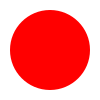

In [4]:
from IPython.display import SVG

model = Model()
svg = model.predict('a goose winning a gold medal')

print(svg)
display(SVG(svg))

In [6]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [7]:
import pandas as pd
import importlib
metric = importlib.import_module('metric')
importlib.reload(metric)

vqa_evaluator = metric.VQAEvaluator()
aesthetic_evaluator = metric.AestheticEvaluator()

2025-04-20 13:55:34.589770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745171734.600777   13214 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745171734.603957   13214 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745171734.615566   13214 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745171734.615584   13214 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745171734.615585   13214 computation_placer.cc:177] computation placer alr

In [11]:
# score gpt4o generated images
import ast
import numpy as np
from PIL import Image

# Load the first sample from descriptions.csv
descriptions_df = pd.read_csv('data/descriptions.csv')
first_description = descriptions_df.iloc[1]

eval_df = pd.read_csv('data/eval.csv')
first_eval = eval_df.iloc[1]

# Load the image
image_path = 'data/gray_coat.png'  # Assuming the image is saved with this name
image = Image.open(image_path)

# Prepare the inputs for scoring - need to parse the string representations
questions = ast.literal_eval(first_eval['question'])
choices = ast.literal_eval(first_eval['choices'])
answers = ast.literal_eval(first_eval['answer'])

# Calculate VQA score - don't wrap in additional lists
vqa_score = vqa_evaluator.score(questions, choices, answers, image)

# Calculate aesthetic score
aesthetic_score = aesthetic_evaluator.score(image)

# Apply image processing as done in the metric.score function
image_processor = metric.ImageProcessor(image=image, seed=0).apply()
processed_image = image_processor.image.copy()

# Calculate final fidelity score
instance_score = metric.harmonic_mean(vqa_score, aesthetic_score, beta=0.5)

print(f"VQA Score: {vqa_score}")
print(f"Aesthetic Score: {aesthetic_score}")
print(f"Final Fidelity Score: {instance_score}")

VQA Score: 0.9996758976500401
Aesthetic Score: 0.5749330520629883
Final Fidelity Score: 0.8709845773271212


In [13]:
# Fix duplicate IDs in descriptions.csv and order rows by id
def fix_duplicate_ids(csv_path):
    """
    Fix duplicate IDs in a CSV file by assigning new unique IDs to duplicates.
    Then order rows by ID.
    """
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Check for duplicate IDs
    duplicate_mask = df['id'].duplicated(keep='first')
    duplicate_count = duplicate_mask.sum()
    
    if duplicate_count > 0:
        print(f"Found {duplicate_count} duplicate IDs in {csv_path}")
        
        # Get the maximum ID value
        max_id = df['id'].max()
        
        # Assign new IDs to duplicates
        new_ids = list(range(max_id + 1, max_id + 1 + duplicate_count))
        df.loc[duplicate_mask, 'id'] = new_ids
        
        print(f"Assigned new IDs to duplicates")
    else:
        print(f"No duplicate IDs found in {csv_path}")
    
    # Sort the dataframe by ID
    df = df.sort_values(by='id')
    print(f"Sorted rows by ID")
    
    # Save the fixed and sorted CSV
    df.to_csv(csv_path, index=False)
    print(f"Fixed and sorted CSV saved to {csv_path}")
    
    # Return the fixed dataframe
    return df

# Fix descriptions.csv
fixed_descriptions_df = fix_duplicate_ids('data/descriptions.csv')

# Fix eval.csv if needed
# First check if eval.csv has the same issue
eval_df = pd.read_csv('data/eval.csv')
duplicate_eval_ids = eval_df['id'].duplicated(keep='first').sum()

if duplicate_eval_ids > 0:
    fixed_eval_df = fix_duplicate_ids('data/eval.csv')
else:
    print("No duplicate IDs found in data/eval.csv")
    # Still sort by ID even if no duplicates
    eval_df = eval_df.sort_values(by='id')
    eval_df.to_csv('data/eval.csv', index=False)
    print("Sorted data/eval.csv by ID")


No duplicate IDs found in data/descriptions.csv
Sorted rows by ID
Fixed and sorted CSV saved to data/descriptions.csv
No duplicate IDs found in data/eval.csv
Sorted data/eval.csv by ID
